In [1]:
import SimpleITK as sitk
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, center_of_mass
import cv2

In [2]:
in_dicom = 0

scan_path = 'data/testing_data/scans/'
seg_path = 'data/testing_data/segs/'

scans = []
segs = []

# Sitk is shitty for dicom so convert to 
scan_names = glob.glob(os.path.join(scan_path, '*.nii'), recursive = True) + glob.glob(os.path.join(scan_path, '*.nii.gz'), recursive = True) + glob.glob(os.path.join(scan_path, '*.nrrd'), recursive = True)
seg_names = glob.glob(os.path.join(seg_path, '*.nii'), recursive = True) + glob.glob(os.path.join(seg_path, '*.nii.gz'), recursive = True) + glob.glob(os.path.join(seg_path, '*.nrrd'), recursive = True)

# match scans and segmentations with indices of array
# change to naming convention from rad tech
for scan_name in scan_names:
    scan = sitk.GetArrayFromImage(sitk.ReadImage(scan_name))
    scans.append(scan)
    for seg_name in seg_names:
        if seg_name.split('/')[-1] == scan_name.split('/')[-1]:
            seg = sitk.GetArrayFromImage(sitk.ReadImage(seg_name))
            segs.append(seg)
            
print(f'scans: {len(scans)}')
print(f'segs: {len(segs)}')

scans: 1
segs: 1


In [3]:
rois = []

for idx, scan in enumerate(scans):
    mask = segs[idx] > 0
    rois.append(np.multiply(scan, mask))

In [4]:
def expand_segmentation(segmentation):
    # define convolution kernel for dilation
    kernel = np.ones((3, 3), np.uint8)
    
    # dilate
    return cv2.dilate(segmentation, kernel, iterations=5)
    

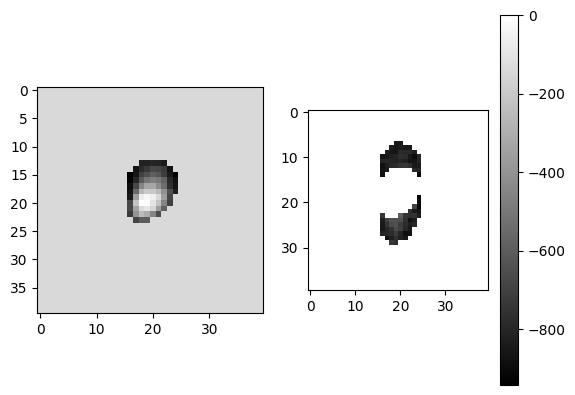

In [5]:
neighbor_segs = []
neighbor_rois = []

for idx, seg in enumerate(segs):
    neighbor_mask = expand_segmentation(seg)
    neighbor_mask = np.subtract(neighbor_mask, seg)
    neighbor_mask = neighbor_mask.astype(np.double)
    neighbor_segs.append(neighbor_mask)
    neighbor_roi = np.multiply(scans[idx], neighbor_mask)
    neighbor_rois.append(neighbor_roi)

plt.subplot(1,2,1)
plt.imshow(rois[0][20], cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(neighbor_rois[0][20], cmap = 'gray')
plt.colorbar()    

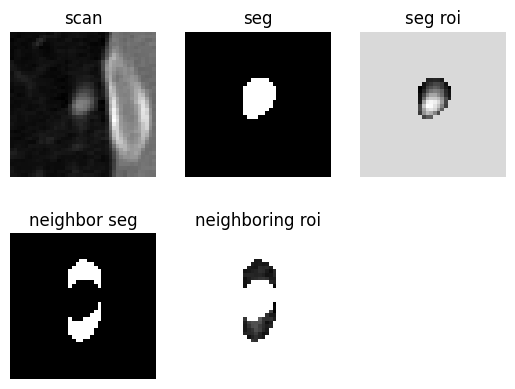

In [6]:
scan_num = 0
slice_ax = 20

# visualize mask creation results
plt.subplot(2,3,1)
plt.imshow(scans[scan_num][slice_ax,:,:], cmap = 'gray')
plt.axis('off')
plt.title('scan')
plt.subplot(2,3,2)
plt.imshow(segs[scan_num][slice_ax,:,:], cmap = 'gray')
plt.axis('off')
plt.title('seg')
plt.subplot(2,3,3)
plt.axis('off')
plt.title('seg roi')
plt.imshow(rois[scan_num][slice_ax,:,:], cmap='gray')
plt.subplot(2,3,4)
plt.axis('off')
plt.title('neighbor seg')
plt.imshow(neighbor_segs[scan_num][slice_ax,:,:], cmap='gray')
plt.subplot(2,3,5)
plt.axis('off')
plt.title('neighboring roi')
plt.imshow(neighbor_roi[slice_ax,:,:], cmap='gray')

In [7]:
# from med physics textbook pg 60
def local_contrast(img, img_bg):
    i1 = np.mean(img)
    i2 = np.mean(img_bg)
    return np.abs((i1 - i2) / i2)
    

In [8]:
img_1 = np.ones((1,1,1))
img_2 = np.ones((1,1,1)) * 99
img_3 = np.ones((1,2,3))
img_4 = np.ones((1,2,3)) * 99

matching_contrast = local_contrast(img_1, img_1)
print(f'Matching: {matching_contrast}')
mismatching_contrast = local_contrast(img_1, img_2)
print(f'Mismatching: {mismatching_contrast}')
wrong_dimension_contrast = local_contrast(img_1,img_3)
print(f'Wrong dimension: {wrong_dimension_contrast}')
wrong_dim_mismatch_contrast = local_contrast(img_1, img_4)
print(f'Mismatch of numbers and dimensions: {wrong_dim_mismatch_contrast}')
print('^^ we can see that the dimensionality of the images is not affecting the contrast ^^')

Matching: 0.0
Mismatching: 0.98989898989899
Wrong dimension: 0.0
Mismatch of numbers and dimensions: 0.98989898989899
^^ we can see that the dimensionality of the images is not affecting the contrast ^^


In [9]:
contrast = local_contrast(rois[0][rois[0] > 0], neighbor_rois[0][neighbor_rois[0] > 0])
print(f'Image to neighboring tissue local contrast: {contrast}')

Image to neighboring tissue local contrast: 0.6476814516129032
